In [1]:
import pandas as pd
import numpy as np

In [2]:
products = pd.read_csv('amazon_baby.csv')

In [3]:
products.head()

,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5


In [4]:
def remove_punctuation(text):
    import string
    return text.translate(None, string.punctuation) 

In [5]:
products = products.fillna({'review':''})  # fill in N/A's in the review column

In [6]:
products['review_clean'] = products['review'].apply(remove_punctuation)

In [7]:
products.head()

,name,review,rating,review_clean
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3,These flannel wipes are OK but in my opinion n...
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,it came early and was not disappointed i love ...
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,Very soft and comfortable and warmer than it l...
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,This is a product well worth the purchase I h...
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,All of my kids have cried nonstop when I tried...


In [8]:
products = products[products['rating'] != 3]
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)

In [9]:
train_index = pd.read_json('module-9-assignment-train-idx.json')
train_index.columns = ['indexvalue']
id_train = train_index.indexvalue.tolist()

test_index = pd.read_json('module-9-assignment-test-idx.json')
test_index.columns = ['indexvalue']
id_test = test_index.indexvalue.tolist()

In [10]:
train_data = products.iloc[id_train]
test_data = products.iloc[id_test]

In [11]:
train_data.shape, test_data.shape

((133416, 5), (33336, 5))

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
     # Use this token pattern to keep single-letter words
# First, learn vocabulary from the training data and assign columns to words
# Then convert the training data into a sparse matrix
train_matrix = vectorizer.fit_transform(train_data['review_clean'])
# Second, convert the test data into a sparse matrix, using the same word-column mapping
test_matrix = vectorizer.transform(test_data['review_clean'])

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
logistic_model = LogisticRegression()
logistic_model.fit(train_matrix, train_data['sentiment'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [18]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true=test_data['sentiment'], y_pred=logistic_model.predict(test_matrix))
print "Test Accuracy: %s" % accuracy

Test Accuracy: 0.932325413967


In [21]:
baseline = float(len(test_data[test_data['sentiment'] == 1]))/len(test_data)
print "Baseline accuracy (majority class classifier): %s" % baseline

Baseline accuracy (majority class classifier): 0.842782577394


In [23]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_true=test_data['sentiment'],
                        y_pred=logistic_model.predict(test_matrix),
                        labels=logistic_model.classes_)    # use the same order of class as the LR model.
print ' target_label | predicted_label | count '
print '--------------+-----------------+-------'
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(logistic_model.classes_):
    for j, predicted_label in enumerate(logistic_model.classes_):
        print '{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j])

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  3789
     -1       |        1        |  1452
      1       |       -1        |   804
      1       |        1        | 27291


In [24]:
cmat

array([[ 3789,  1452],
       [  804, 27291]])

In [25]:
from sklearn.metrics import precision_score
precision = precision_score(y_true=test_data['sentiment'], 
                            y_pred=logistic_model.predict(test_matrix))
print "Precision on test data: %s" % precision

Precision on test data: 0.949483352468


In [27]:
from sklearn.metrics import recall_score
recall = recall_score(y_true=test_data['sentiment'],
                      y_pred=logistic_model.predict(test_matrix))
print "Recall on test data: %s" % recall

Recall on test data: 0.971382808329


Note. If you are using scikit-learn, make sure to use predict_proba() function, not decision_function(). Also, note that the predict_proba() function returns the probability values for both classes +1 and -1. So make sure to extract the second column, which correspond to the class +1.

In [28]:
probabilities = logistic_model.predict_proba(test_matrix)[:,1]

In [29]:
probabilities

array([ 0.78334549,  0.99999924,  0.93327115, ...,  0.99999482,
        0.99999757,  0.98176068])

In [30]:
#Predict label using threshold probability = 0.9, rather than the default 0.5
predict_plus = probabilities[probabilities >= 0.9]
predict_minus = probabilities[probabilities < 0.9]

In [31]:
len(predict_plus), len(predict_minus), len(probabilities)

(25069, 8267, 33336)

In [43]:
prediction = pd.Series(probabilities).apply(lambda x: +1 if x > 0.9 else -1)

In [45]:
result = prediction == test_data['sentiment']

In [48]:
precision_09 = precision_score(y_true=test_data['sentiment'], 
                            y_pred=prediction)
print "Precision on test data with 0.9 probability threshold: %s" % precision_09

recall_09 = recall_score(y_true=test_data['sentiment'],
                      y_pred=prediction)
print "Recall on test data with 0.9 probability threshold: %s" % recall_09

Precision on test data with 0.9 probability threshold: 0.98153097451
Recall on test data with 0.9 probability threshold: 0.875814201815


Now, we will explore various different values of tresholds, compute the precision and recall scores, and then plot the precision-recall curve. Use 100 equally spaced values between 0.5 and 1. In Python, we run

In [49]:
threshold_values = np.linspace(0.5, 1, num=100)
print threshold_values

[ 0.5         0.50505051  0.51010101  0.51515152  0.52020202  0.52525253
  0.53030303  0.53535354  0.54040404  0.54545455  0.55050505  0.55555556
  0.56060606  0.56565657  0.57070707  0.57575758  0.58080808  0.58585859
  0.59090909  0.5959596   0.6010101   0.60606061  0.61111111  0.61616162
  0.62121212  0.62626263  0.63131313  0.63636364  0.64141414  0.64646465
  0.65151515  0.65656566  0.66161616  0.66666667  0.67171717  0.67676768
  0.68181818  0.68686869  0.69191919  0.6969697   0.7020202   0.70707071
  0.71212121  0.71717172  0.72222222  0.72727273  0.73232323  0.73737374
  0.74242424  0.74747475  0.75252525  0.75757576  0.76262626  0.76767677
  0.77272727  0.77777778  0.78282828  0.78787879  0.79292929  0.7979798
  0.8030303   0.80808081  0.81313131  0.81818182  0.82323232  0.82828283
  0.83333333  0.83838384  0.84343434  0.84848485  0.85353535  0.85858586
  0.86363636  0.86868687  0.87373737  0.87878788  0.88383838  0.88888889
  0.89393939  0.8989899   0.9040404   0.90909091  0.

In [55]:
precision_all = []
recall_all = []

for value in threshold_values:
    pred = pd.Series(probabilities).apply(lambda x: +1 if x >= value else -1)
    precision = precision_score(y_true=test_data['sentiment'], 
                            y_pred=pred)
    recall = recall_score(y_true=test_data['sentiment'],
                      y_pred=pred)
    precision_all.append(precision)
    recall_all.append(recall)

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})

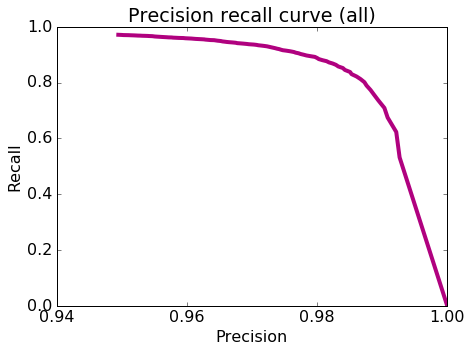

In [57]:
plot_pr_curve(precision_all, recall_all, 'Precision recall curve (all)')

From the test set, select all the reviews for all products with the word 'baby' in them. If you are using SFrame, generate a binary mask with apply() and index test_data with the mask. Save the selection to a new data frame named baby_reviews.

In [59]:
baby_reviews = test_data[test_data['name'].apply(lambda x: 'baby' in str(x).lower())]

In [61]:
test_data.shape, baby_reviews.shape

((33336, 5), (6611, 5))

In [63]:
baby_matrix = vectorizer.transform(baby_reviews['review_clean'])
probabilities = logistic_model.predict_proba(baby_matrix)[:,1]

In [64]:
precision_all = []
recall_all = []

for value in threshold_values:
    pred = pd.Series(probabilities).apply(lambda x: +1 if x >= value else -1)
    precision = precision_score(y_true=baby_reviews['sentiment'], 
                            y_pred=pred)
    recall = recall_score(y_true=baby_reviews['sentiment'],
                      y_pred=pred)
    precision_all.append(precision)
    recall_all.append(recall)

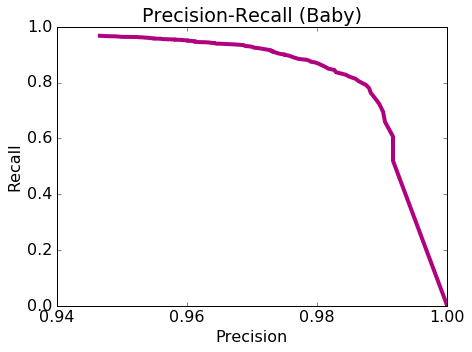

In [65]:
plot_pr_curve(precision_all, recall_all, "Precision-Recall (Baby)")